In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from matplotlib.animation import FuncAnimation
from matplotlib import rc

In [2]:
class Problem:
    def __init__(self):
        self.dx = 0.1
        self.x0 = 7.0
        self.y0 = 4.0
        self.sigx = 2.25
        self.sigy = 2.25
        self.a2 = 1.10
        self.xa0 = 3.0
        self.ya0 = 3.5
        self.sigax = 1.25
        self.sigay = 1.25
        self.x_bound = (0.0,10.0)
        self.y_bound = (0.0,10.0)
        self.x=np.arange(self.x_bound[0],self.x_bound[1],self.dx)
        self.y=np.arange(self.y_bound[0],self.y_bound[1],self.dx)
        self.X,self.Y = np.meshgrid(self.x,self.y)
        self.Xs = np.zeros(self.X.shape)
        self.Ys = np.zeros(self.Y.shape)
        self.cx = 0.0
        self.cy = 0.0
        self.amp = -20.0
        self.rad = np.sqrt(6**2+6**2)
        self.width = 1.5

    def f(self,x,y):
        return 10.0*np.exp(-((x-self.x0)**2/2.0/self.sigx**2 + (y-self.y0)**2/2.0/self.sigy**2))

    def h(self,x,y):
        return 10.0*np.exp(-((x-self.xa0)**2/2.0/self.sigax**2 + (y-self.ya0)**2/2.0/self.sigay**2))

    def swirl(self,x,y):
        u = np.array([[x],[y]])
        c = np.array([[self.cx],[self.cy]])
        r = np.sqrt((x-self.cx)**2+(y-self.cy)**2)
        theta = self.amp*np.exp( -(r-self.rad     )**2/self.width**2) + self.amp*np.exp( -(r-self.rad*0.5 )**2/self.width**2)*0.75
        theta *= np.pi/180
        rotz = np.matrix([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
        swirl_ = rotz*(u-c)+c
        return swirl_[0,0],swirl_[1,0]

    def objFun(self,x_):
        xt,yt = self.swirl(x_[0],x_[1])
        return 1.0/(self.f(xt,yt)+self.a2*self.h(xt,yt)+1.0)

    def get_field(self,x,y):
        X,Y = np.meshgrid(x,y)
        Xs = np.zeros(X.shape)
        Ys = np.zeros(Y.shape)
        for i in range(len(self.x)):
            for j in range(len(self.y)):
                Xs[i,j],Ys[i,j] = self.swirl(X[i,j],Y[i,j])
        g = self.f(Xs,Ys)+self.a2*self.h(Xs,Ys)
        return g

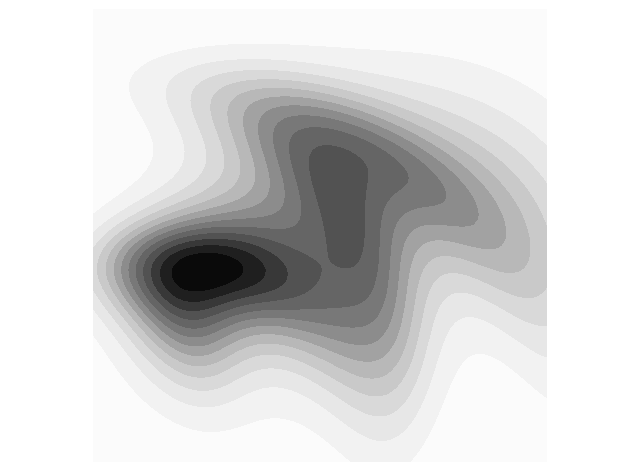

In [3]:
prob = Problem()

xs = prob.X
ys = prob.Y
f = prob.get_field(prob.x,prob.y)

fig=plt.figure(figsize=(8,6), dpi=100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
lvl = np.linspace(np.min(np.min(f)),np.max(np.max(f)),15)
ax.contourf(xs,ys,f,cmap=plt.get_cmap('Greys'),levels=lvl)
ax.axis('equal')
ax.axis('off')
# plt.savefig('opti_problem.png',dpi=200)
plt.show()
plt.close()

In [4]:
def cg_descent_scipy(objFun, xInit):
    xSol,funValue,nEvalF,nGradF,tmp1,xSteps = opt.fmin_cg(objFun, \
                                                          xInit, \
                                                          full_output=1, \
                                                          disp=1, \
                                                          retall=1, \
                                                          maxiter=30)
    xSteps= np.array(xSteps)
    return xSteps

In [5]:
xInit = np.array([8.5,4.0])
track_cg = cg_descent_scipy(prob.objFun, xInit)
nStep = track_cg.shape[0]

Optimization terminated successfully.
         Current function value: 0.090347
         Iterations: 14
         Function evaluations: 208
         Gradient evaluations: 52


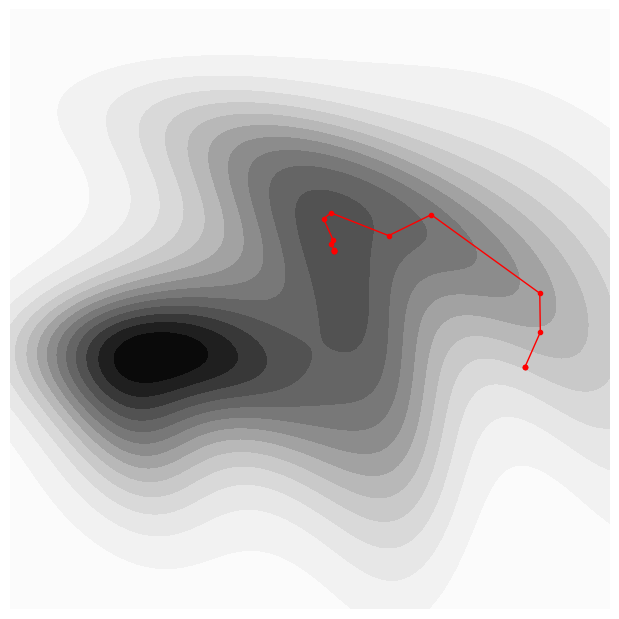

In [6]:
fig=plt.figure(figsize=(6,6), dpi=100, facecolor='w', edgecolor='k')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

plt.rcParams["animation.html"] = "jshtml"
ax = fig.add_subplot(111)
lvl = np.linspace(np.min(np.min(f)),np.max(np.max(f)),15)
ax.set_xlim(prob.x_bound)
ax.set_ylim(prob.y_bound)
ax.axis('equal')
ax.axis('off')

xdata, ydata = [], []
lines = [plt.plot([], [], '-r',lw=1,marker='o',markersize='3')[0]]
ax.contourf(xs,ys,f,cmap=plt.get_cmap('Greys'),levels=lvl)

def update(frame):
    xdata.append(track_cg[frame,0])
    ydata.append(track_cg[frame,1])
    lines[0].set_data(xdata, ydata)
    return lines

ani = FuncAnimation(fig, update, frames=range(nStep),  blit=True,interval=1000)

rc('animation', html='html5')
ani

# plt.savefig('opti_conj_grad_descent.png',dpi=200)
# plt.show()
# plt.close()

In [7]:
def myPSO(objFun,nParticle,bounds,maxIter):
    nDim = bounds.shape[0]
    eps = 1e-2
    LARGE = 1e10 
    alpha = 0.075
    beta = 0.5
    gamma = 0.25
    dt = 0.75
    
    X0 = np.zeros([nParticle,nDim])
    F0 = np.ones([nParticle,1])*LARGE
    F1 = np.ones([nParticle,1])*LARGE+1
    U = np.zeros([nParticle,nDim])
    for i in range(nDim):
        X0[:,i] = np.random.random(nParticle)*(bounds[i,1]-bounds[i,0])+bounds[i,0]
    Xinit = np.copy(X0)    
    X1 = np.copy(X0)
    xGlob = np.array([np.mean(X0,0)])
    
    for ip in range(nParticle):
        F0[ip] = objFun(X1[ip,:])
    
    xArr = np.zeros([nParticle,maxIter])
    yArr = np.zeros([nParticle,maxIter])
    iter = 0
    xArr[:,iter] = X0[:,0]
    yArr[:,iter] = X0[:,1] 
    while iter < maxIter-1:
        print('PSO iter',iter, end="")
        U0 = (X1-X0)
        U1 = alpha*(np.random.random([nParticle,nDim])-0.5)*(bounds[i,1]-bounds[i,0])+beta*U0+gamma*(xGlob-X0)
        X1 = X0+dt*U1
        for ip in range(nParticle):
            F1[ip] = objFun(X1[ip,:])
        indImproved,tmp = np.where(F1<F0)
        if (indImproved.shape[0]>0):
            print(' #improved',indImproved.shape[0])
            indTmp = np.argmin(F1[indImproved])
            indMin = indImproved[indTmp]
            xGlob = np.array([X1[indMin,:]])
            X0[indImproved,:] =X1[indImproved,:]
            F0[indImproved] =F1[indImproved]
        for j in range(nDim): # check bounds
            indUnder = np.where(X1[:,j]<bounds[j,0])
            if ~(len(indUnder)==0):
                X0[indUnder,j] = bounds[j,0]+0.5
            indOver = np.where(X1[:,j]>bounds[j,1])
            if ~(len(indOver)==0):
                X0[indOver,j] = bounds[j,1]-0.5
        iter+=1
        xArr[:,iter] = X0[:,0]
        yArr[:,iter] = X0[:,1]

    xStepsFOO = (xArr,yArr)
    return X0,xStepsFOO,Xinit

In [8]:
bounds =np.array([(0.0,10.0),(0.0,10.0)],float)
nParticle=20
maxIter = 30
X0,xStepsFOO,Xinit = myPSO(prob.objFun,nParticle,bounds,maxIter)
XPSO = xStepsFOO[0]
YPSO = xStepsFOO[1]
nIter = XPSO.shape[1]
nIter =20

PSO iter 0 #improved 18
PSO iter 1 #improved 18
PSO iter 2 #improved 13
PSO iter 3 #improved 14
PSO iter 4 #improved 12
PSO iter 5 #improved 11
PSO iter 6 #improved 10
PSO iter 7 #improved 11
PSO iter 8 #improved 8
PSO iter 9 #improved 9
PSO iter 10 #improved 7
PSO iter 11 #improved 5
PSO iter 12 #improved 9
PSO iter 13 #improved 9
PSO iter 14 #improved 12
PSO iter 15 #improved 4
PSO iter 16 #improved 5
PSO iter 17 #improved 6
PSO iter 18 #improved 4
PSO iter 19 #improved 4
PSO iter 20 #improved 4
PSO iter 21 #improved 4
PSO iter 22 #improved 4
PSO iter 23 #improved 3
PSO iter 24 #improved 2
PSO iter 25 #improved 4
PSO iter 26 #improved 1
PSO iter 27 #improved 1
PSO iter 28 #improved 1


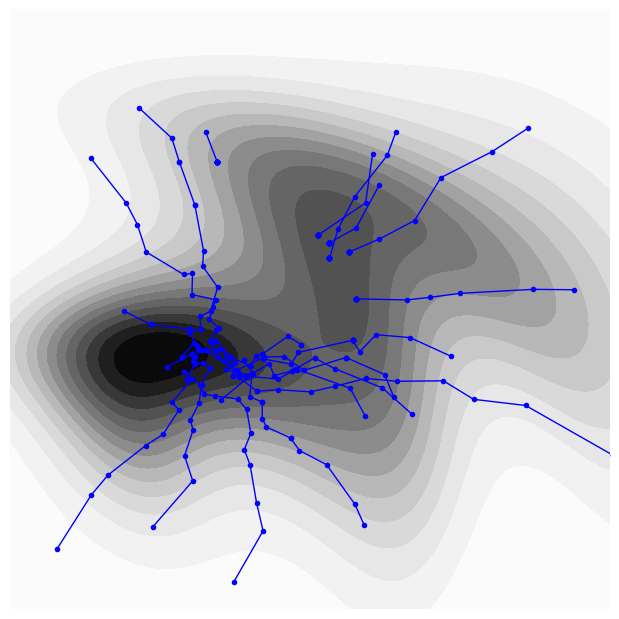

In [9]:
fig=plt.figure(figsize=(6,6), dpi=100, facecolor='w', edgecolor='k')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

plt.rcParams["animation.html"] = "jshtml"
ax = fig.add_subplot(111)
lvl = np.linspace(np.min(np.min(f)),np.max(np.max(f)),15)
ax.set_xlim(prob.x_bound)
ax.set_ylim(prob.y_bound)
ax.axis('equal')
ax.axis('off')

lines = []
for j in range(nParticle):
    lobj = ax.plot([],[],lw=1,color='b',marker='o',markersize=3)[0]
    lines.append(lobj)

ax.contourf(xs,ys,f,cmap=plt.get_cmap('Greys'),levels=lvl)

def update(frame):
    for lnum,line in enumerate(lines):
        line.set_data(XPSO[lnum,:frame], YPSO[lnum,:frame]) # set data for each line separately. 
    return lines

ani = FuncAnimation(fig, update, frames=range(nStep),  blit=True,interval=1000)

rc('animation', html='html5')
ani

# plt.savefig('opti_pso.png',dpi=200)
# plt.show()
# plt.close()